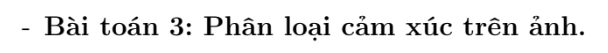

# Import libraries

In [17]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

# Datasets pre-processing

In [19]:
train_dir = 'train'
test_dir = 'test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

In [20]:
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [21]:
label2idx, idx2label

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 {0: 'angry',
  1: 'disgust',
  2: 'fear',
  3: 'happy',
  4: 'neutral',
  5: 'sad',
  6: 'surprise'})

# Pytorch DataLoader

In [80]:
test_img_path = 'train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)

In [81]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx,
                 split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=self.train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )

            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1
        return img, label

In [82]:
batch_size = 32
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
test_dataset = ImageDataset(test_dir, True, label2idx, split='test')

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False)

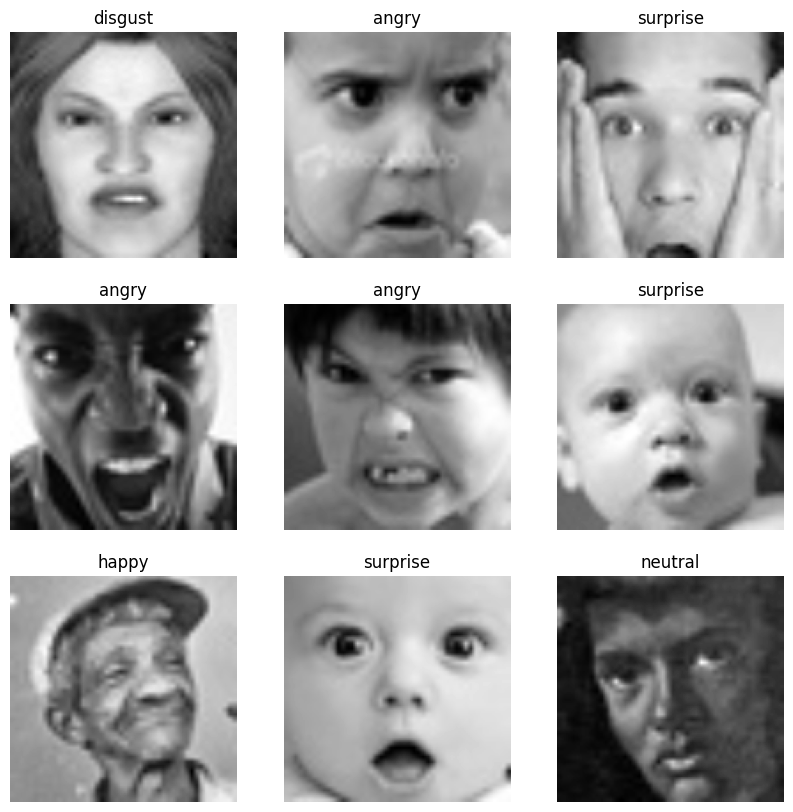

In [83]:
image_batch, label_batch = next(iter(train_loader))

plt.figure(figsize=(10, 10))
for i in range(9) :
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min ()
    maxv = image_batch[i].numpy().max ()
    plt.imshow (np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")

# Build MLP network

In [72]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [73]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64

model = MLP(input_dims, hidden_dims, output_dims).to(device)

# Initiate loss function and optimizer

In [74]:
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Accuracy function

In [75]:
def compute_accuracy(y_hat, y_true):
    y_hat = torch.Tensor(y_hat).to(device)
    y_true = torch.Tensor(y_true).to(device)
    y_hat = torch.argmax(y_hat, dim=1)
    correct = (y_hat == y_true).float().sum().item()
    accuracy = correct / len(y_true)
    return accuracy

# Training

In [76]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

In [77]:
for epoch in range(epochs):
    train_batch_loss = []
    train_target = []
    train_predict = []

    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        y_pred = model(X_samples)
        # compute avg loss in a batch
        loss = criterion(y_pred, y_samples)
        loss.backward()
        optimizer.step()

        train_batch_loss.append(loss.item())
        train_predict += y_pred.tolist()
        train_target += y_samples.tolist()
    
    epoch_train_loss = np.mean(train_batch_loss)
    train_losses.append(epoch_train_loss)
    train_accs.append(compute_accuracy(train_predict, train_target))

    val_batch_loss = []
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            y_pred = model(X_samples)
            loss = criterion(y_pred, y_samples)
            val_batch_loss.append(loss.item())
            val_predict += y_pred.tolist()
            val_target += y_samples.tolist()


    epoch_val_loss = np.mean(val_batch_loss)
    val_losses.append(epoch_val_loss)
    val_accs.append(compute_accuracy(val_predict, val_target))
    
    print(f'EPOCH {epoch+1}:\tTraining loss : {epoch_train_loss: .3f}\tValidation loss : {epoch_val_loss: .3f}')

EPOCH 1:	Training loss :  1.864	Validation loss :  1.817
EPOCH 2:	Training loss :  1.796	Validation loss :  1.782
EPOCH 3:	Training loss :  1.769	Validation loss :  1.761
EPOCH 4:	Training loss :  1.745	Validation loss :  1.724
EPOCH 5:	Training loss :  1.695	Validation loss :  1.671
EPOCH 6:	Training loss :  1.650	Validation loss :  1.641
EPOCH 7:	Training loss :  1.625	Validation loss :  1.627
EPOCH 8:	Training loss :  1.605	Validation loss :  1.615
EPOCH 9:	Training loss :  1.588	Validation loss :  1.608
EPOCH 10:	Training loss :  1.570	Validation loss :  1.592
EPOCH 11:	Training loss :  1.553	Validation loss :  1.582
EPOCH 12:	Training loss :  1.537	Validation loss :  1.573
EPOCH 13:	Training loss :  1.519	Validation loss :  1.578
EPOCH 14:	Training loss :  1.501	Validation loss :  1.578
EPOCH 15:	Training loss :  1.486	Validation loss :  1.558
EPOCH 16:	Training loss :  1.469	Validation loss :  1.556
EPOCH 17:	Training loss :  1.453	Validation loss :  1.559
EPOCH 18:	Training loss

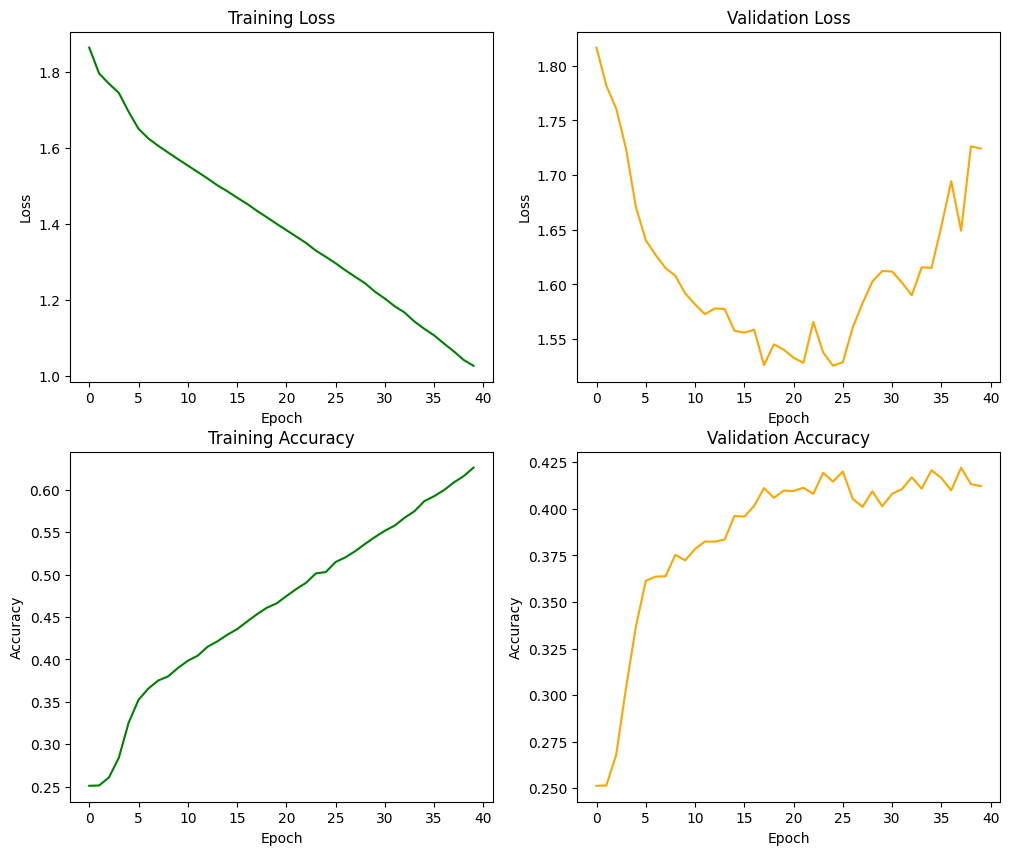

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

# Evaluation

In [79]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict += outputs.tolist()
        test_target += y_samples.tolist()

    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set:')
    print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.4190582334912232
